# Sparse + Low-Rank Splitting

---

Suppose we are given a data matrix $A$, and know that it has a form $$A=L+S,$$ where $L$ is of low-rank and $S$ is sparse, but we know neither the rank of $L$ nor the non-zero entries of $S$. 

_Can we recover $L$ and $S$?_

The answer is YES, with high probability and with an efficient algorithm. 

_Sparse + Low-rank_ splitting can be successfully applieed to video surveilance, face recognition, latent semantic indexing, and ranking and collaborative filtering. 

## Prerequisites

The reader should be familiar with linear algebra concepts, particularly SVD and its properties and algorithms.
 
## Competences 

The reader should be able to apply sparse + low-rank splitting to real problems.

## References

For more details see [E. J. Candes, X. Li, Y. Ma, and J. Wright, Robust Principal Component Analysis?][CLMW09]

__Credits__: The author wishes to thank Dimitar Ninevski, a former IAESTE intern, for collecting and preparing some of the material. 

[CLMW09]: http://arxiv.org/abs/0912.3599 "Emmanuel J. Candes, Xiaodong Li, Yi Ma, John Wright, 'Robust Principal Component Analysis?', arXiv:0912.3599, 2009."

---

## Definitions

Let $A\in\mathbb{R}^{m\times n}$ have rank $r$, and let $A=U\Sigma V^T$ be its SVD.

The __nuclear norm__ of $A$ is $\|A\|_*=\sum\limits_{i=1}^r \sigma_i(A)$.

Let $\|A\|_1=\sum\limits_{i,j} |A_{ij}|$ denote the $1$-norm of $A$ seen as a long vector.

Let $\|A\|_{\infty}=\max\limits_{i,j} |A_{ij}|$ denote the $\infty$-norm of $A$ seen as a long vector.

Given $\tau>0$, the __shrinkage operator__ $\mathcal{S}_{\displaystyle\tau}:\mathbb{R}\to \mathbb{R}$ is defined by
$\mathcal{S}_{\displaystyle\tau}(x)=\mathop{\mathrm{sign}}(x)\max\{|x|-\tau,0\}$,
and is extended to matrices by applying it to each element. 

Given $\tau>0$, the __singluar value thresholding operator__ is
$\mathcal{D}_{\displaystyle\tau}(A)=U \mathcal{S}_{\displaystyle\tau} (\Sigma) V^T$.


## Facts

Let $A=L+S$ be the splitting that we are looking for.

1. The problem can be formulated as 
$\mathop{\textrm{arg min}}\limits_{\displaystyle \mathop{\mathrm{rank}}(L)\leq k} \|A-L\|_2$.

2. The problem makes sense if the __incoherence conditions__ 
$$
\max_{\displaystyle i} \| U_{:,1:r}^T e_i\|_2^2\leq \frac{\mu r}{m}, \quad
\max_{\displaystyle i} \| V_{:,1:r}^T e_i\|_2^2\leq \frac{\mu r}{n}, \quad
\|UV^T\|_{\infty} \leq \sqrt{\frac{\mu r}{m\cdot n}},
$$
hold for some parameter $\mu$.

3. If the incoherence conditions are satisfied, the __Principal Component Pursuit estimate__,
$$
\mathop{\textrm{arg min}}\limits_{\displaystyle L+S=A} \|L\|_*+\lambda \|S\|_2,
$$
exactly recovers $L$ and $S$.

4. _Principal Component Pursuit by Alternating Directions_ algorithm finds the above estimate
    1. _Initialization_: $S=0$, $Y=0$, $L=0$, $\mu>0$, $\delta=10^{-7}$.
    2. _Iterations_: while $\|A-L-S\|_F>\delta\|A\|_F$ repeat
        1. _SV Thresholding_: $L=\mathcal{D}_{\displaystyle \mu^{-1}}(A-S-\mu^{-1}Y)$
        2. _Shrinnkage_: $S=\mathcal{S}_{\displaystyle \lambda \mu^{-1}}(A-L+\mu^{-1}Y)$
        3. _Updating_: $Y=Y+\mu(A-L-S)$

### Example - Random matrices

In [2]:
# Shrinkage
function Shr{T}(x::Array{T},τ::T)
    sign(x).*max(abs(x)-τ,0)
end

Shr (generic function with 1 method)

In [3]:
A=rand(3,5)

3x5 Array{Float64,2}:
 0.632364  0.262297  0.0673186  0.425167   0.940008
 0.222066  0.457137  0.040467   0.0337316  0.443855
 0.78266   0.540549  0.507582   0.406922   0.242508

In [4]:
Shr(A,0.5)

3x5 Array{Float64,2}:
 0.132364  0.0       0.0        0.0  0.440008
 0.0       0.0       0.0        0.0  0.0     
 0.28266   0.040549  0.0075818  0.0  0.0     

In [5]:
# Singular value thresholding
function D{T}(A::Array{T}, τ::T)
    # U,σ,V=svd(A)
    # This can be replaced by a faster approach
    U,R=qr(A)
    u,σ,V=svd(R)
    # U*=u
    S=Shr(σ,τ)
    k=sum(S.>zero(T))
    # U[:,1:k]*diagm(S[1:k])*V[:,1:k]'
    U*(u[:,1:k]*diagm(S[1:k]))*V[:,1:k]'
end

D (generic function with 1 method)

In [6]:
D(A,0.5)

3x5 Array{Float64,2}:
 0.470101  0.311241  0.142657   0.268537  0.526918
 0.240173  0.160247  0.0796826  0.135975  0.253503
 0.478885  0.331633  0.225555   0.259158  0.35154 

In [8]:
A

3x5 Array{Float64,2}:
 0.632364  0.262297  0.0673186  0.425167   0.940008
 0.222066  0.457137  0.040467   0.0337316  0.443855
 0.78266   0.540549  0.507582   0.406922   0.242508

In [10]:
function PCPAD{T}(A::Array{T})
    # Initialize
    δ=1.0e-7
    tol=δ*vecnorm(A)
    m,n=size(A)
    S=zeros(A)
    Y=zeros(A)
    L=zeros(A)
    μ=(m*n)/(4*(norm(A[:],1)))
    @show μ
    μ1=one(T)/μ
    λ=1/sqrt(max(m,n))
    λμ1=λ*μ1
    ν=1e20
    maxiter=1000
    iterations=0
    # Iterate
    while (ν>tol) && iterations<maxiter
        iterations+=1
        L=D(A-S+μ1*Y,μ1)
        S=Shr(A-L+μ1*Y,λμ1)
        T=A-L-S
        Y=Y+μ*T
        ν=vecnorm(T)
    end
    L,S, iterations
end

PCPAD (generic function with 1 method)

In [11]:
L,S,iter=PCPAD(A)

μ = 0.6245177729121861


(
3x5 Array{Float64,2}:
 0.370369  0.262297  0.0674918  0.238053  0.196839
 0.222066  0.157268  0.0404668  0.142732  0.118021
 0.456299  0.323152  0.0831506  0.293283  0.242508,

3x5 Array{Float64,2}:
 0.261995  -0.0       -0.000173154   0.187114   0.743169
 0.0        0.299869   0.0          -0.109      0.325834
 0.326361   0.217397   0.424431      0.113639  -0.0     ,

599)

In [12]:
rank(L),norm(A-L-S)

(1,1.7529983157828346e-7)

In [14]:
m=100
n=100
k=10
sparsity=0.1
L=rand(m,k)*rand(k,n)
rank(L)

10

In [15]:
S=10*sprand(m,n,sparsity)
A=L+S
nnz(S), rank(A)

(951,100)

In [16]:
@time L1,S1,iters=PCPAD(A);

μ = 0.08380802704076178
  2.792328 seconds (25.64 k allocations: 410.584 MB, 2.48% gc time)


In [17]:
iters, rank(L1), norm(L), norm(L-L1), norm(full(S)), norm(S-S1)

(188,10,259.81619521251815,3.7908452792999245e-5,54.81790724969199,3.097074240900438e-5)

Although there might be no convergence, the splitting is still good. 

In [18]:
S1, full(S)

(
100x100 Array{Float64,2}:
  9.1868   -0.0        0.0      …  -0.0  -0.0       -0.0       0.0    
 -0.0      -0.0        0.0          0.0   0.0       -0.0      -0.0    
  0.0       0.0        9.06137      0.0  -0.0        0.0       0.0    
 -0.0       4.99525    5.35393      0.0  -0.0       -0.0      -0.0    
 -0.0       3.64054    0.0         -0.0   0.0        0.0      -0.0    
  0.0       0.0        0.0      …   0.0   0.0        0.0       0.0    
 -0.0       0.0       -0.0         -0.0   0.0       -0.0      -0.0    
  0.0      -0.0        0.0         -0.0   0.0        0.0       7.98565
  0.0       0.509372  -0.0         -0.0   0.0        0.0      -0.0    
 -0.0       0.0       -0.0         -0.0   0.0       -0.0       0.0    
 -0.0       0.0        0.0      …   0.0   0.0       -0.0       0.0    
  0.25455   0.0        0.0         -0.0  -0.0        0.0      -0.0    
  0.0      -0.0        0.0         -0.0   0.0       -0.0      -0.0    
  ⋮                             ⋱                

### Example - Face recognition

We will try to recover missing features. The images are chosen from the 
[Yale Face Database](http://vision.ucsd.edu/content/yale-face-database).


In [19]:
using Images, Colors

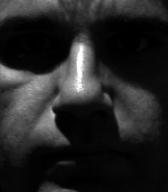

In [20]:
# First a single image - no help
img=load("files/17.jpg")

In [21]:
show(img)

Gray Images.Image with:
  data: 168x192 Array{ColorTypes.Gray{FixedPointNumbers.UFixed{UInt8,8}},2}
  properties:
    colorspace: Gray
    spatialorder:  x y

In [22]:
# Compute the splitting and show number of iterations
A=float(img.data)
L,S,iters=PCPAD(A)
iters, rank(L), norm(A), norm(A-L-S)

μ = 1.7641865800268313


(1000,83,34.627418508422586,0.00014505594109621498)

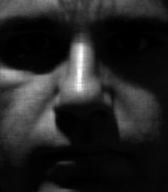

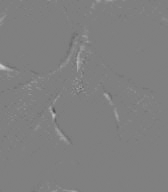

(nothing,nothing)

In [25]:
display(Image(map(Gray,map(Images.Clamp01NaN(L),L)'))),
display(Image(map(Gray,map(Images.Clamp01NaN(S+0.5),S+0.5)')))

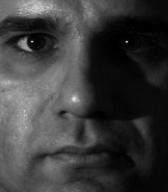

In [26]:
# Another image
img=load("files/19.jpg")

In [27]:
A=float(img.data)
L,S,iters=PCPAD(A)
@show iters, rank(L), norm(A), norm(A-L-S)

μ = 1.0895784475075525
(iters,rank(L),norm(A),norm((A - L) - S)) = (1000,84,51.14350860422345,0.00012107473870239976)


(1000,84,51.14350860422345,0.00012107473870239976)

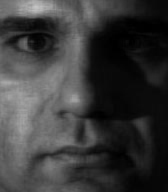

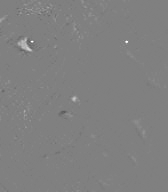

(nothing,nothing)

In [28]:
display(Image(map(Gray,map(Images.Clamp01NaN(L),L)'))), 
display(Image(map(Gray,map(Images.Clamp01NaN(S+0.5),S+0.5)')))

### Example - Multiple images

Each image of $168 \times 192$ pixels is converted to a vector of length 32256. 
All vectors are stacked in the columns of matrix $A$, and the low-rank + sparse splitting 
of $A$ is computed.

In [29]:
# Load all images in the collection
dir="./files/yaleB08/"
files=readdir(dir)

64-element Array{ByteString,1}:
 ".directory"              
 "yaleB08_P00A+000E+00.pgm"
 "yaleB08_P00A+000E+20.pgm"
 "yaleB08_P00A+000E+45.pgm"
 "yaleB08_P00A+000E-20.pgm"
 "yaleB08_P00A+000E-35.pgm"
 "yaleB08_P00A+005E+10.pgm"
 "yaleB08_P00A+005E-10.pgm"
 "yaleB08_P00A+010E+00.pgm"
 "yaleB08_P00A+010E-20.pgm"
 "yaleB08_P00A+015E+20.pgm"
 "yaleB08_P00A+020E+10.pgm"
 "yaleB08_P00A+020E-10.pgm"
 ⋮                         
 "yaleB08_P00A-070E+00.pgm"
 "yaleB08_P00A-070E+45.pgm"
 "yaleB08_P00A-070E-35.pgm"
 "yaleB08_P00A-085E+20.pgm"
 "yaleB08_P00A-085E-20.pgm"
 "yaleB08_P00A-095E+00.pgm"
 "yaleB08_P00A-110E+15.pgm"
 "yaleB08_P00A-110E+40.pgm"
 "yaleB08_P00A-110E+65.pgm"
 "yaleB08_P00A-110E-20.pgm"
 "yaleB08_P00A-120E+00.pgm"
 "yaleB08_P00A-130E+20.pgm"

In [30]:
n=length(files)-1
img=Array(Any,n)
B=Array(Any,n)
for i=1:n
    img[i]=load(joinpath(dir,files[i+1]))
    B[i]=float(img[i].data)
end

In [32]:
# See the images - last 9 images are meaningless
# for i=1:n; display(img[i]); end

In [33]:
# Form the big matrix - each image is converted to a column vector
mi,ni=size(img[1])
A=Array(Float64,mi*ni,n-9)
for i=1:n-9
    A[:,i]=vec(B[i])
end
size(A)

(32256,54)

In [34]:
# Now the big SVDs - 3 minutes
@time L,S,iters=PCPAD(A)
iters, rank(L), norm(A), norm(A-L-S)

μ = 1.0288757354994815
178.787267 seconds (82.53 k allocations: 135.759 GB, 31.45% gc time)


(564,27,363.9778534354257,2.0951145993897957e-5)

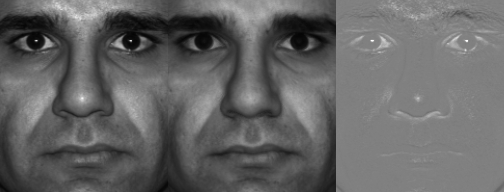

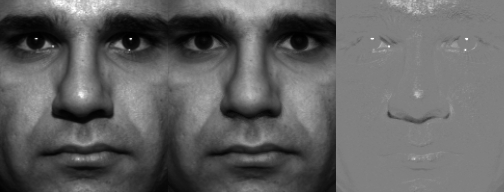

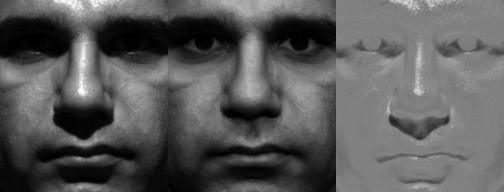

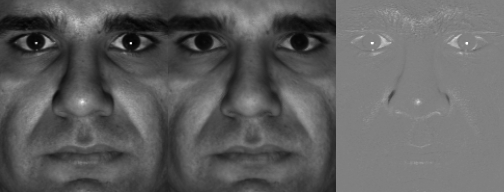

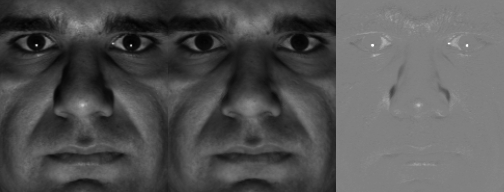

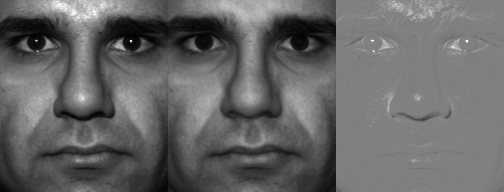

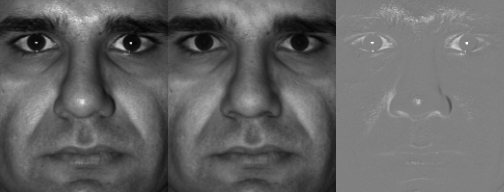

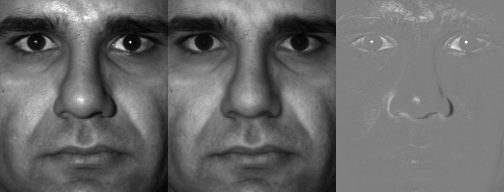

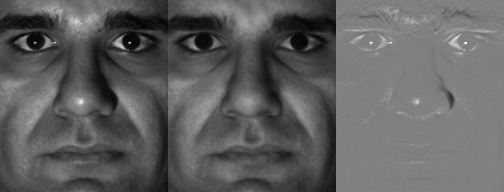

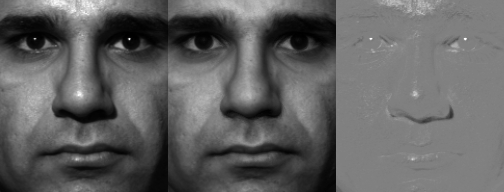

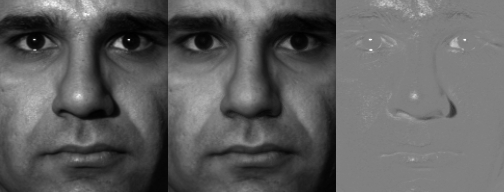

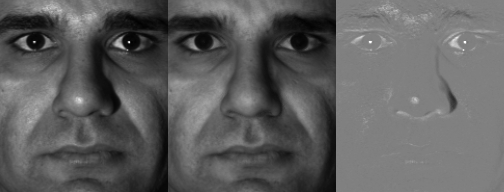

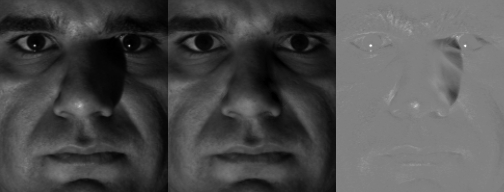

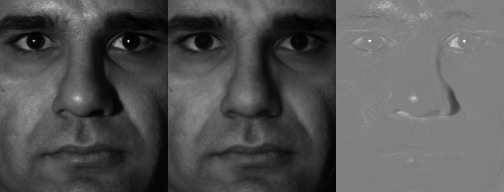

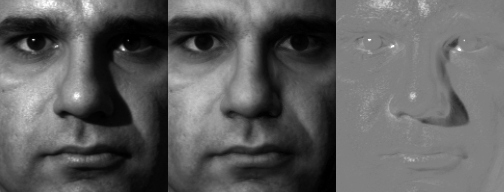

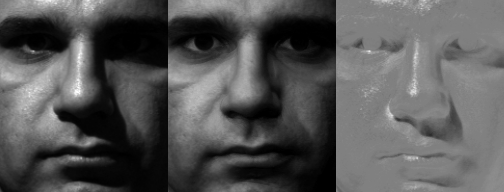

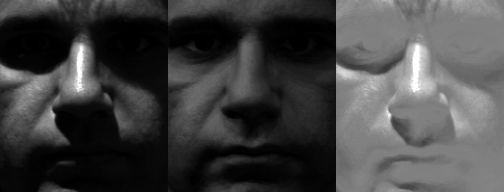

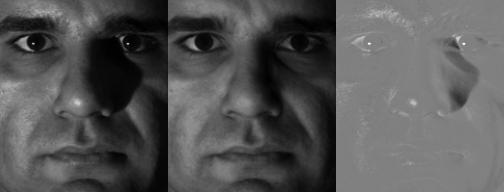

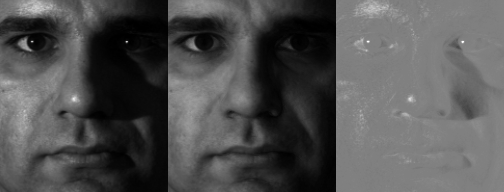

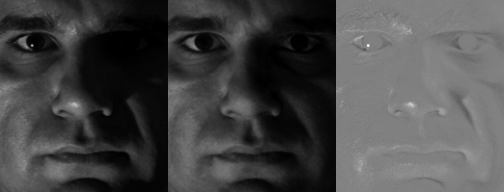

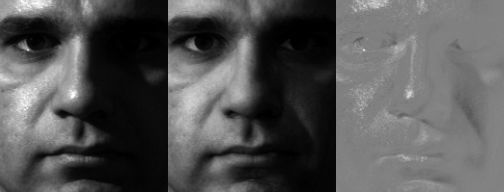

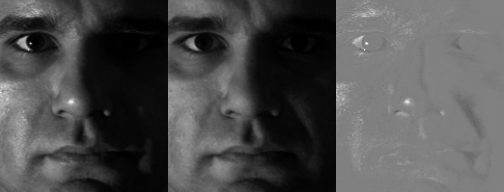

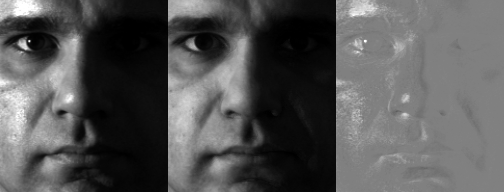

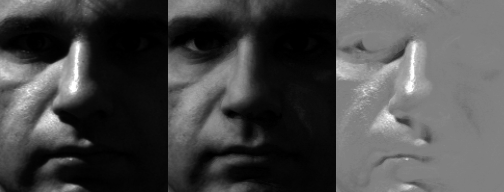

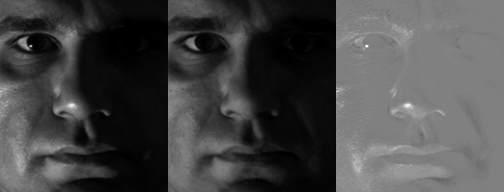

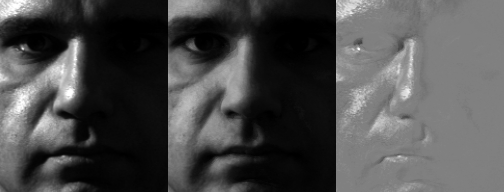

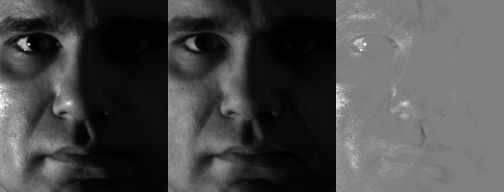

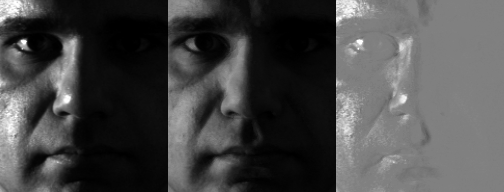

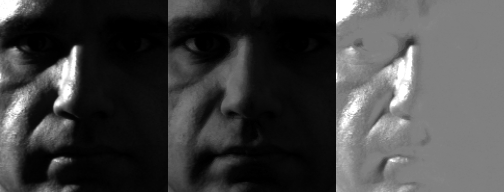

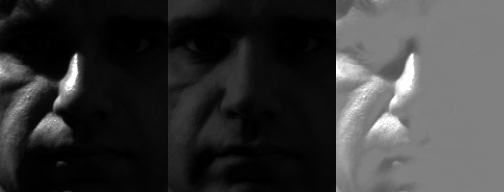

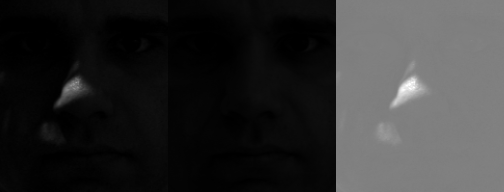

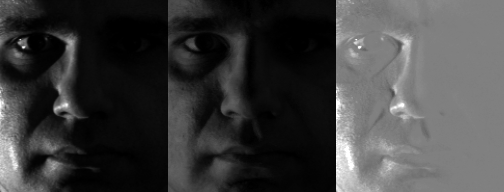

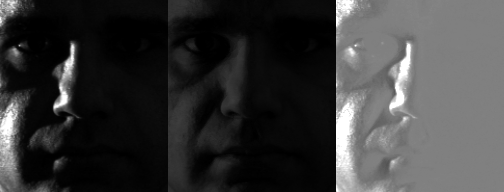

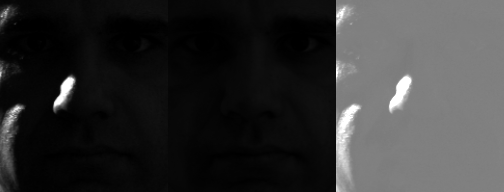

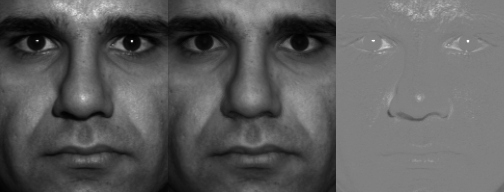

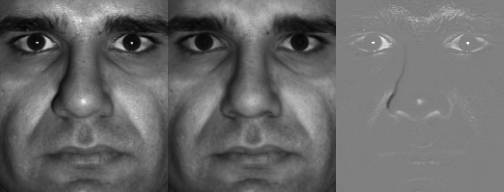

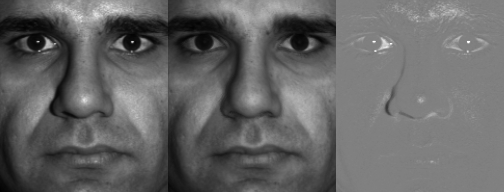

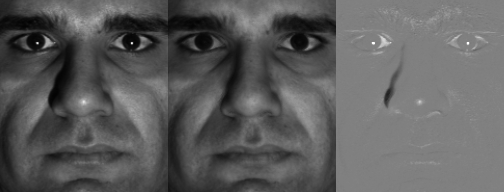

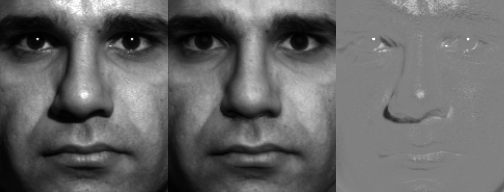

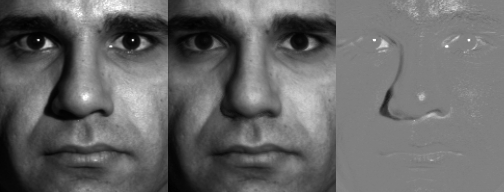

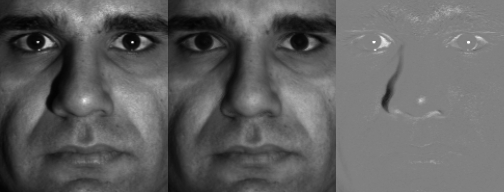

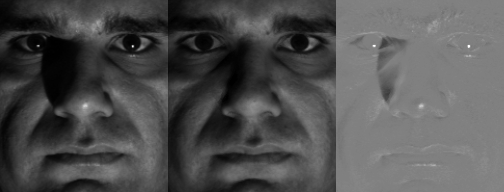

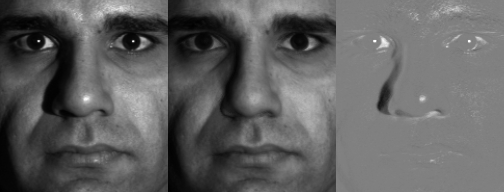

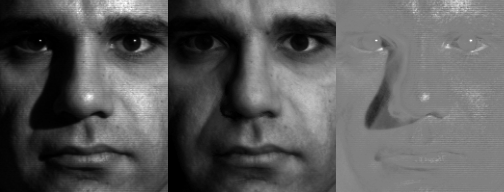

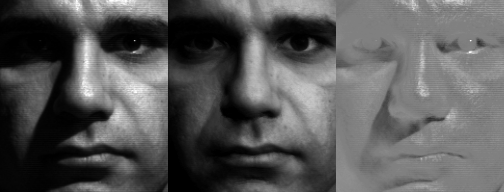

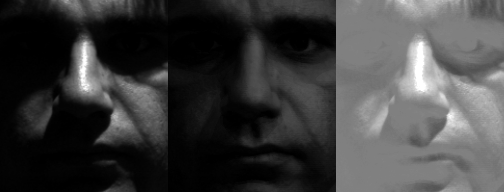

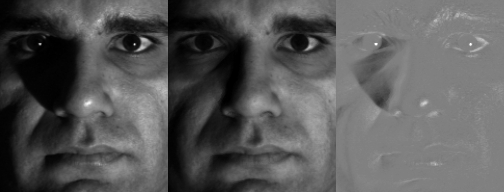

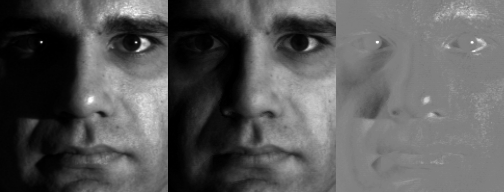

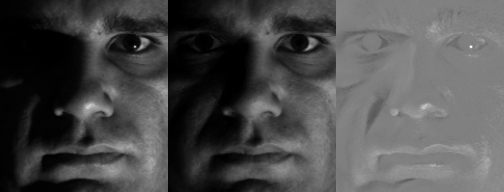

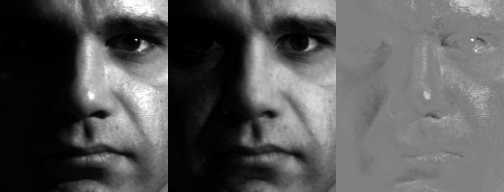

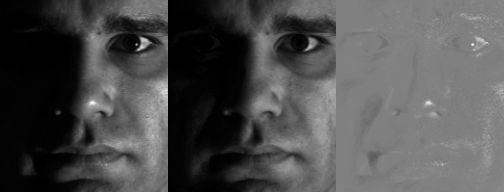

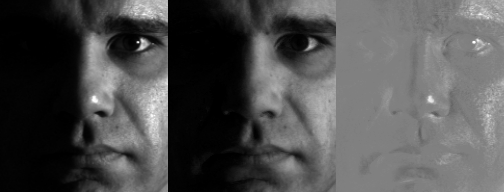

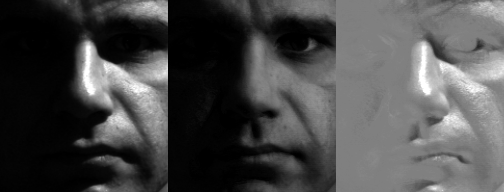

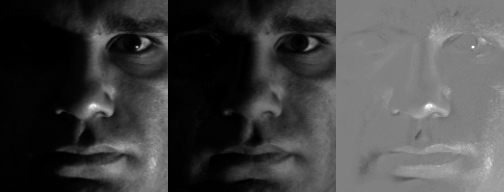

In [36]:
for i=1:n-9
    Li=reshape(L[:,i],mi,ni)
    Si=reshape(S[:,i],mi,ni)+0.5
    display(vcat( img[i], Image(map(Gray,map(Images.Clamp01NaN(Li),Li))),
    Image(map(Gray,map(Images.Clamp01NaN(Si),Si)))))
end

### Example - Mona Lisa's smile

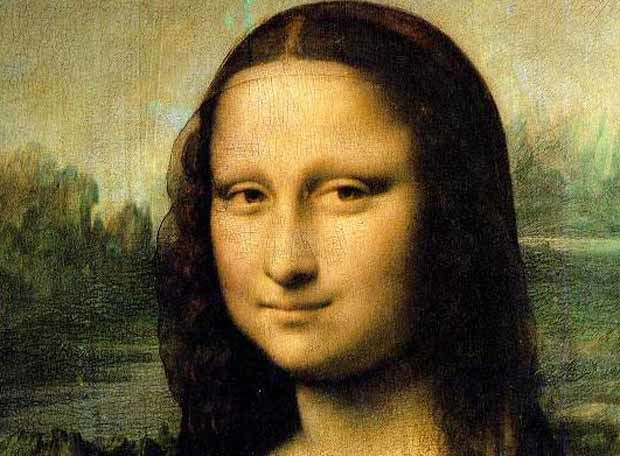

In [37]:
img=load("files/mona-lisa_1.jpg")

In [38]:
imgsep=separate(img)
fieldnames(imgsep)

2-element Array{Symbol,1}:
 :data      
 :properties

In [30]:
imgsep.properties

Dict{ASCIIString,Any} with 3 entries:
  "colorspace"   => "RGB"
  "colordim"     => 3
  "spatialorder" => ASCIIString["y","x"]

In [39]:
size(imgsep.data)

(456,620,3)

In [32]:
# 7 minutes
@time RL,RS,Riter=PCPAD(float(imgsep.data[:,:,1]))
GL,GS,Giter=PCPAD(float(imgsep.data[:,:,2]))
BL,BS,Biter=PCPAD(float(imgsep.data[:,:,3]))
Giter, rank(GL), norm(float(imgsep.data[:,:,2])), 
norm(float(imgsep.data[:,:,2])-GL-GS)

μ = 0.5961272467102573
132.173952 seconds (155.49 k allocations: 35.057 GB, 8.48% gc time)
μ = 0.6796352970068623
μ = 1.1278606242265707


(545,246,221.7432116692531,1.002977978882978e-5)

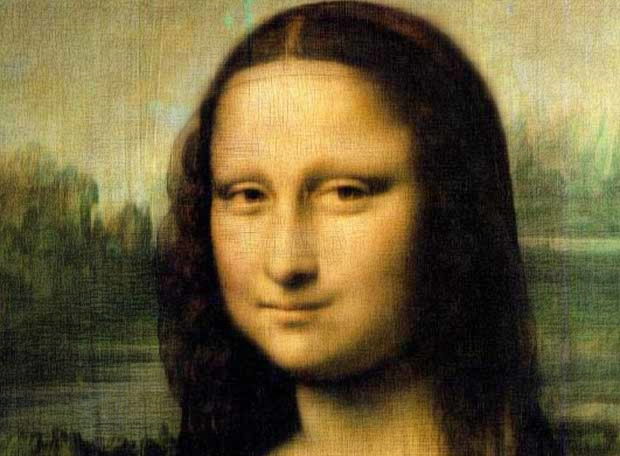

In [33]:
# Mona Lisa's low-rank and sparse component
Image(map(RGB,RL,GL,BL))

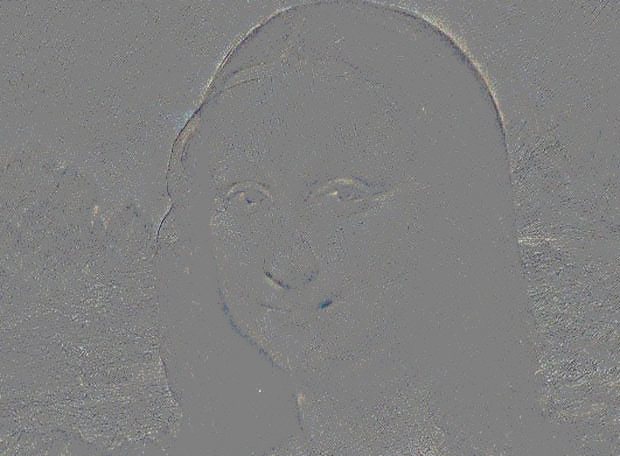

In [34]:
Image(map(RGB,RS+0.5,GS+0.5,BS+0.5))

### Example - Mona Lisa's hands

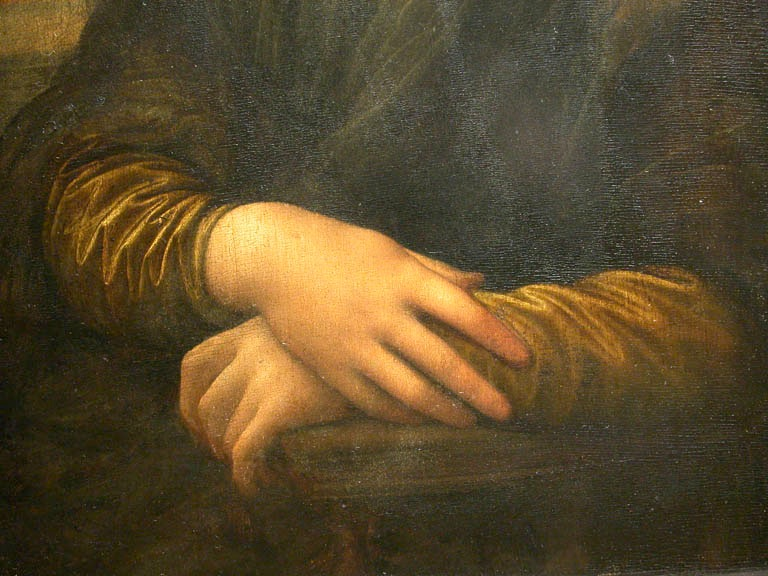

In [34]:
img=load("files/Mona_Lisa_detail_hands.jpg")

In [35]:
imgsep=separate(img)
# 7 minutes
@time RL,RS,Riter=PCPAD(float(imgsep.data[:,:,1]))
GL,GS,Giter=PCPAD(float(imgsep.data[:,:,2]))
BL,BS,Biter=PCPAD(float(imgsep.data[:,:,3]))
Giter, rank(GL), norm(float(imgsep.data[:,:,2])), 
norm(float(imgsep.data[:,:,2])-GL-GS)

μ = 0.71226065731073
184.707345 seconds (87.37 k allocations: 44.723 GB, 8.64% gc time)
μ = 0.8682249892135205
μ = 1.4680512174183444


(397,315,205.57272143820586,9.788398887375607e-6)

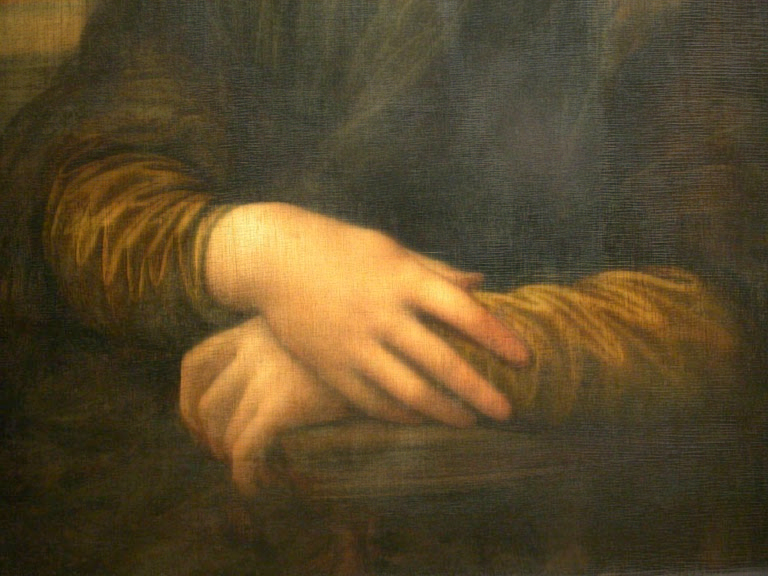

In [36]:
Image(map(RGB,RL,GL,BL))

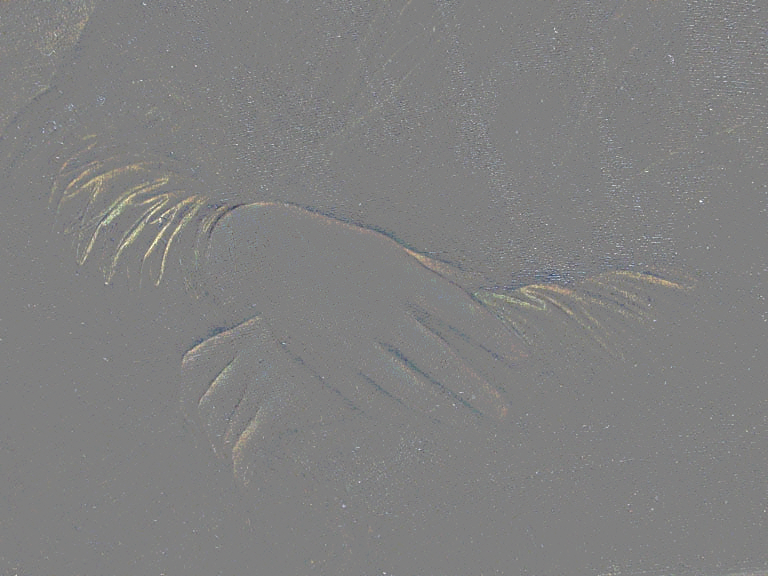

In [37]:
Image(map(RGB,RS+0.5,GS+0.5,BS+0.5))